In [1]:
import sys
sys.path.insert(0,'..')

import yaml
import os
from yaml import Loader as Loader
from pathlib import Path
import pandas as pd
import numpy as np
import json
from sklearn.metrics import roc_auc_score

from analyze_results import (
    extract_result,
    aggregate_runs,
    from_model_outputs_calc_rcc_auc,
)
from analyze_results import (
    format_results2,
    improvement_over_baseline,
    from_model_outputs_calc_pr_auc,
    from_model_outputs_calc_rpp,
    from_model_outputs_calc_roc_auc,
    from_model_outputs_calc_arc_auc
)

from utils.utils_wandb import init_wandb, wandb
from ue4nlp.ue_scores import *

In [2]:
def choose_metric(metric_type):
    if metric_type  == "rejection-curve-auc":
        return "rejection-curve-auc"
    elif metric_type == "rcc-auc":
        return from_model_outputs_calc_rcc_auc
    elif metric_type == "rpp":
        return from_model_outputs_calc_rpp
    else:
        raise ValueError("Wrong metric type!")


def get_one_table(runs_dir, metric_types=["rejection-curve-auc", "roc-auc", "rcc-auc", "pr-auc", "rpp"], baseline=None, methods=None):
    default_methods = {
        "bald": bald,
        "sampled_max_prob": sampled_max_prob,
        "variance": probability_variance,
        #"var.ratio": var_ratio,
        #"sampled_entropy": mean_entropy,
    }
    
    if methods is None:
        methods = default_methods

    table = []
    for metric_type in metric_types:
        metric = choose_metric(metric_type=metric_type)

        agg_res = aggregate_runs(
            runs_dir, methods=methods, metric=metric
        )

        if agg_res.empty:
            print("Broken\n")
            continue

        if metric_type == "rcc-auc":
            final_score = format_results2(agg_res, percents=False)
        elif metric_type == "rpp":
            final_score = format_results2(agg_res, percents=True)
        elif metric_type == "accuracy":
            final_score = format_results2(agg_res, percents=True)
        else:
            final_score = improvement_over_baseline(agg_res, baseline_col="max_prob", baseline=baseline, metric=metric_type, percents=True, subtract=True)
        table.append(final_score)
    res_table = pd.concat(table, axis=1)
    res_table.columns = metric_types
    # fix for rcc-auc and rpp
    if 'baseline (max_prob)' not in res_table.index:
        res_table.loc['baseline (max_prob)'] = 0
    for metric in ['rcc-auc', 'rpp']:
        try:
            res_table[metric].loc['baseline (max_prob)'] = res_table[metric].loc['max_prob']
        except:
            pass
    try:
        res_table = res_table.drop(['max_prob', 'count'])
    except:
        res_table = res_table.drop(['max_prob'])
    return res_table


def collect_tables(run_dirs, names, metric_types=["rejection-curve-auc", "roc-auc", "rcc-auc", "pr-auc", "rpp"], baseline=None, methods=None):
    all_tables = []
    for run_dir, name in zip(run_dirs, names):
        buf_table = get_one_table(run_dir, metric_types, baseline, methods)
        #print(buf_table)
        # add name to index
        indices = [(name, ind) for ind in list(buf_table.index)]
        baseline_name = 'baseline|'+'|'.join(name.split('|')[1:])
        buf_table.loc[baseline_name] = buf_table.loc['baseline (max_prob)']
        # add reindex
        indices = indices + [(baseline_name, 'max_prob')]
        
        index = pd.MultiIndex.from_tuples(indices, names=['Method', 'UE Score'])
        buf_table.index = index
        buf_table.drop((name, 'baseline (max_prob)'), inplace=True)
        # add buf_table to final_table
        all_tables.append(buf_table)
    return pd.concat(all_tables)


def collect_datasets(runs_dirs, names, dataset_names, metric_types=["rejection-curve-auc", "roc-auc", "rcc-auc", "pr-auc", "rpp"], baselines={}, methods=None):
    all_tables = []
    for run_dir, dataset_name in zip(runs_dirs, dataset_names):
        #try:
        dataset_table = collect_tables(run_dir, names, metric_types, baselines.get(dataset_name, None), methods=methods)
        columns = pd.MultiIndex.from_tuples([(dataset_name, ind) for ind in list(dataset_table.columns)])
        dataset_table.columns = columns
        all_tables.append(dataset_table)
        #except:
        #    print(f'empty dir {run_dir}')
    return pd.concat(all_tables, axis=1)

In [ ]:
import os 
    
def choose_agg_func(method):
    agg_methods = {
        "bald": bald,
        "sampled_max_prob": sampled_max_prob,
        "variance": probability_variance,
    }
    if method=='nuq' or method=='nuq_best' or method=='nuq_best1':
        nuq_aleatoric = lambda x: np.squeeze(x[0], axis=-1)
        nuq_epistemic = lambda x: np.squeeze(x[1], axis=-1)
        nuq_total = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {
            "nuq_aleatoric": nuq_aleatoric,
            "nuq_epistemic": nuq_epistemic,
            "nuq_total": nuq_total,
        }
    elif method=='mahalanobis':
        maha_dist = lambda x: np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"mahalanobis_distance": maha_dist}
    elif method=='ddu' or method=='ddu_maha':
        ddu = lambda x: -np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"ddu": ddu}
    elif method=='mc_mahalanobis':
        sm_maha_dist = lambda x: np.squeeze(x[:, 1:], axis=-1).max(1)
        agg_methods = {"sampled_mahalanobis_distance": sm_maha_dist}
    return agg_methods

    
metric_types=['rejection-curve-auc', "rcc-auc", 'rpp']
methods = ['mahalanobis', 'nuq_best1']
regs = ['raw', 'reg', 'metric']
spectralnorm = ['sn', 'no_sn']
dataset_names = ['QQP']
dataset_fnames = ['qqp']
names = []
tables = []
baselines = []
for method in methods:
    for reg in regs:
        for sn in spectralnorm:
            for noise in ['', '/noise_0.01', '/noise_0.05', '/noise_0.1', '/noise_0.15', '/noise_0.2', '/noise_0.25']:
                run_dirs = []
                name_sn = ''
                if len(noise):
                    names = [f'{method}|{reg}|{sn}|{noise}']
                else:
                    names = [f'{method}|{reg}|{sn}|/noise_0.00']
                for name in dataset_fnames:
                    if len(noise):
                        noise_ = '_0.1'+noise
                    else:
                        noise_ = noise
                    model_series_dir = f'../workdir/run_glue_for_model_series/electra_{reg}_{sn}/{name}/0.0{noise_}/{method}'
                    run_dirs.append([model_series_dir])
                agg_func = choose_agg_func(method)
                try:
                    res_df = collect_datasets(run_dirs, names, dataset_names, metric_types=metric_types, baselines={}, methods=agg_func)
                    baselines.append(res_df.iloc[-1:])
                    tables.append(res_df.iloc[:-1])
                    print(model_series_dir)
                except:
                    print('pass')
                    pass

In [20]:
baselines_all = pd.concat([pd.concat(baselines)]).reset_index()

In [21]:
table_all = pd.concat([pd.concat(tables)]).reset_index()

In [22]:
table_nuq = table_all[(table_all['UE Score'] == 'nuq_total')].reset_index(drop=True)

In [23]:
table_maha = table_all[(table_all['UE Score'] == 'mahalanobis_distance')].reset_index(drop=True)

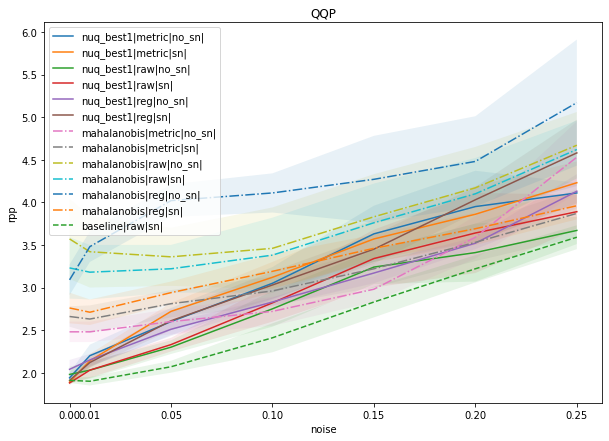

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

metric = 'rpp'
dataset = 'QQP'

all_methods = np.array([m.split('/')[0] for m in table_nuq['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    noise_levels = []
    for noise in ['0.00', '0.01', '0.05', '0.1', '0.15', '0.2', '0.25']:
        full_method = method + f'/noise_{noise}'
        row = table_nuq.iloc[table_nuq['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        noise_levels.append(float(noise))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    plt.plot(noise_levels, curve_mean, label=full_method.split('/')[0])
    plt.fill_between(noise_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    
all_methods = np.array([m.split('/')[0] for m in table_maha['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    noise_levels = []
    for noise in ['0.00', '0.01', '0.05', '0.1', '0.15', '0.2', '0.25']:
        full_method = method + f'/noise_{noise}'
        row = table_maha.iloc[table_maha['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        noise_levels.append(float(noise))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    plt.plot(noise_levels, curve_mean, '-.', label=full_method.split('/')[0])
    plt.fill_between(noise_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    
all_methods = np.array([m.split('/')[0] for m in baselines_all.iloc[[4]]['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    noise_levels = []
    for noise in ['0.00', '0.01', '0.05', '0.1', '0.15', '0.2', '0.25']:
        full_method = method + f'/noise_{noise}'
        row = baselines_all.iloc[baselines_all['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        noise_levels.append(float(noise))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    plt.plot(noise_levels, curve_mean, '--', label=full_method.split('/')[0])#, color = 'r', marker='-')
    plt.fill_between(noise_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    
plt.legend()
plt.xticks([0.0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25])
plt.xlabel('noise')
plt.ylabel(metric)
plt.title('QQP')
plt.show()

In [35]:
nuq1 = table_nuq[table_nuq.Method.str.contains('nuq_best1\|raw\|sn')]
maha1 = table_maha[table_maha.Method.str.contains('mahalanobis\|metric\|no_sn')]
baseline = baselines_all[baselines_all.Method.str.contains('baseline\|raw\|no_sn')].iloc[:7]

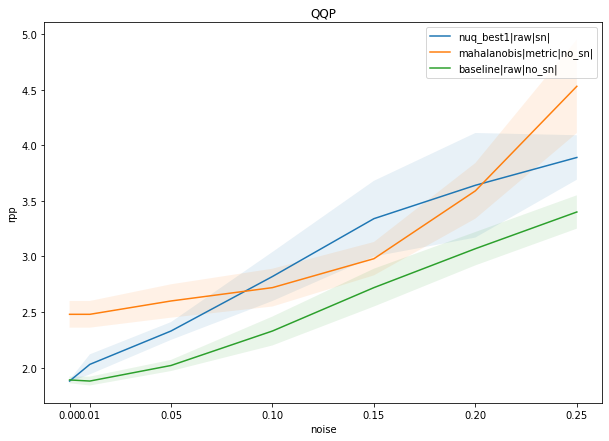

In [36]:
plt.figure(figsize=(10, 7))

for tab in [nuq1,maha1,baseline]:
    curve_mean = []
    curve_std = []
    noise_levels = []
    method = tab.Method.values[0].split('/')[0]
    for noise in ['0.00', '0.01', '0.05', '0.1', '0.15', '0.2', '0.25']:
        full_method = method + f'/noise_{noise}'
        row = tab.iloc[tab['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        noise_levels.append(float(noise))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    plt.plot(noise_levels, curve_mean, label=full_method.split('/')[0])
    plt.fill_between(noise_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    
plt.legend()
plt.xticks([0.0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25])
plt.xlabel('noise')
plt.ylabel(metric)
plt.title('QQP')
plt.show()

In [ ]:
import os 
    
def choose_agg_func(method):
    agg_methods = {
        "bald": bald,
        "sampled_max_prob": sampled_max_prob,
        "variance": probability_variance,
    }
    if method=='nuq' or method=='nuq_best' or method=='nuq_best1':
        nuq_aleatoric = lambda x: np.squeeze(x[0], axis=-1)
        nuq_epistemic = lambda x: np.squeeze(x[1], axis=-1)
        nuq_total = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {
            "nuq_aleatoric": nuq_aleatoric,
            "nuq_epistemic": nuq_epistemic,
            "nuq_total": nuq_total,
        }
    elif method=='mahalanobis':
        maha_dist = lambda x: np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"mahalanobis_distance": maha_dist}
    elif method=='mc_mahalanobis':
        sm_maha_dist = lambda x: np.squeeze(x[:, 1:], axis=-1).max(1)
        agg_methods = {"sampled_mahalanobis_distance": sm_maha_dist}
    return agg_methods

    
metric_types=['rejection-curve-auc', "rcc-auc", 'rpp']
methods = ['mahalanobis', 'nuq_best1']
regs = ['raw']
spectralnorm = ['sn', 'no_sn']
dataset_names = ['SST-2']
dataset_fnames = ['sst2']
names = []
tables = []
baselines = []
for method in methods:
    for reg in regs:
        for sn in spectralnorm:
            for noise in ['', '/noise_0.01', '/noise_0.05', '/noise_0.1', '/noise_0.15', '/noise_0.2', '/noise_0.25']:
                run_dirs = []
                name_sn = ''
                if len(noise):
                    names = [f'{method}|{reg}|{sn}|{noise}']
                else:
                    names = [f'{method}|{reg}|{sn}|/noise_0.00']
                for name in dataset_fnames:
                    if len(noise):
                        noise_ = '_0.1'+noise
                    else:
                        noise_ = noise
                    model_series_dir = f'../workdir/run_glue_for_model_series/electra_{reg}_{sn}/{name}/0.0{noise_}/{method}'
                    run_dirs.append([model_series_dir])
                agg_func = choose_agg_func(method)
                try:
                    res_df = collect_datasets(run_dirs, names, dataset_names, metric_types=metric_types, baselines={}, methods=agg_func)
                    baselines.append(res_df.iloc[-1:])
                    tables.append(res_df.iloc[:-1])
                    print(model_series_dir)
                except:
                    print('pass')
                    pass

../workdir/run_glue_for_model_series/electra_raw_sn/sst2/0.0/mahalanobis
../workdir/run_glue_for_model_series/electra_raw_sn/sst2/0.0_0.1/noise_0.01/mahalanobis
../workdir/run_glue_for_model_series/electra_raw_sn/sst2/0.0_0.1/noise_0.05/mahalanobis
../workdir/run_glue_for_model_series/electra_raw_sn/sst2/0.0_0.1/noise_0.1/mahalanobis
../workdir/run_glue_for_model_series/electra_raw_sn/sst2/0.0_0.1/noise_0.15/mahalanobis
../workdir/run_glue_for_model_series/electra_raw_sn/sst2/0.0_0.1/noise_0.2/mahalanobis
../workdir/run_glue_for_model_series/electra_raw_sn/sst2/0.0_0.1/noise_0.25/mahalanobis
../workdir/run_glue_for_model_series/electra_raw_no_sn/sst2/0.0/mahalanobis
../workdir/run_glue_for_model_series/electra_raw_no_sn/sst2/0.0_0.1/noise_0.01/mahalanobis
../workdir/run_glue_for_model_series/electra_raw_no_sn/sst2/0.0_0.1/noise_0.05/mahalanobis
../workdir/run_glue_for_model_series/electra_raw_no_sn/sst2/0.0_0.1/noise_0.1/mahalanobis
../workdir/run_glue_for_model_series/electra_raw_no_s

In [ ]:
baselines_all = pd.concat([pd.concat(baselines)]).reset_index()

In [ ]:
table_all = pd.concat([pd.concat(tables)]).reset_index()

In [ ]:
table_nuq = table_all[(table_all['UE Score'] == 'nuq_aleatoric')].reset_index(drop=True)
table_maha = table_all[(table_all['UE Score'] == 'mahalanobis_distance')].reset_index(drop=True)

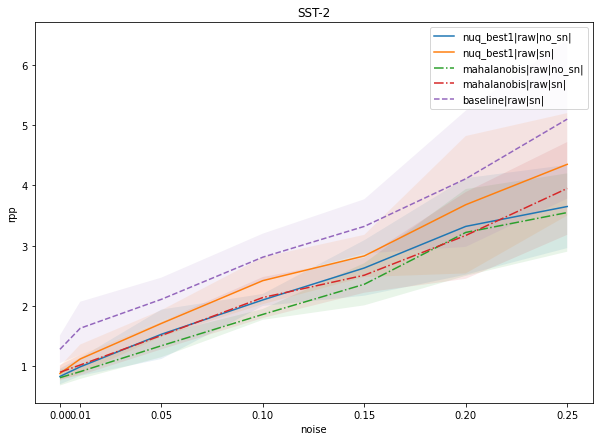

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

metric = 'rpp'
dataset = 'SST-2'

all_methods = np.array([m.split('/')[0] for m in table_nuq['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    noise_levels = []
    for noise in ['0.00', '0.01', '0.05', '0.1', '0.15', '0.2', '0.25']:
        full_method = method + f'/noise_{noise}'
        row = table_nuq.iloc[table_nuq['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        noise_levels.append(float(noise))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    plt.plot(noise_levels, curve_mean, label=full_method.split('/')[0])
    plt.fill_between(noise_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    
all_methods = np.array([m.split('/')[0] for m in table_maha['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    noise_levels = []
    for noise in ['0.00', '0.01', '0.05', '0.1', '0.15', '0.2', '0.25']:
        full_method = method + f'/noise_{noise}'
        row = table_maha.iloc[table_maha['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        noise_levels.append(float(noise))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    plt.plot(noise_levels, curve_mean, '-.', label=full_method.split('/')[0])
    plt.fill_between(noise_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    
all_methods = np.array([m.split('/')[0] for m in baselines_all.iloc[[4]]['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    noise_levels = []
    for noise in ['0.00', '0.01', '0.05', '0.1', '0.15', '0.2', '0.25']:
        full_method = method + f'/noise_{noise}'
        row = baselines_all.iloc[baselines_all['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        noise_levels.append(float(noise))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    plt.plot(noise_levels, curve_mean, '--', label=full_method.split('/')[0])#, color = 'r', marker='-')
    plt.fill_between(noise_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    
plt.legend()
plt.xticks([0.0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25])
plt.xlabel('noise')
plt.ylabel(metric)
plt.title('SST-2')
plt.show()

# SST-2 different dataset usage for train

In [8]:
import os 
    
def choose_agg_func(method):
    agg_methods = {
        "bald": bald,
        "sampled_max_prob": sampled_max_prob,
        "variance": probability_variance,
    }
    if method=='nuq' or method=='nuq_best' or method=='nuq_best1':
        nuq_aleatoric = lambda x: np.squeeze(x[0], axis=-1)
        nuq_epistemic = lambda x: np.squeeze(x[1], axis=-1)
        nuq_total = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {
            "nuq_aleatoric": nuq_aleatoric,
            "nuq_epistemic": nuq_epistemic,
            "nuq_total": nuq_total,
        }
    elif method=='ddu' or method=='ddu_maha':
        ddu = lambda x: -np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"ddu": ddu}
    elif method=='mahalanobis':
        maha_dist = lambda x: np.squeeze(x[0], axis=-1)
        agg_methods = {"mahalanobis_distance": maha_dist}
    elif method=='l_mahalanobis':
        maha_dist = lambda x: np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"l_mahalanobis_distance": maha_dist}
    elif method=='mc_mahalanobis':
        sm_maha_dist = lambda x: np.squeeze(x[:, 1:], axis=-1).max(1)
        agg_methods = {"sampled_mahalanobis_distance": sm_maha_dist}
    return agg_methods

    
metric_types=['rejection-curve-auc', "rcc-auc", 'rpp']
methods = ['mahalanobis', 'l_mahalanobis', 'nuq_best1', 'ddu']
regs = ['raw']
spectralnorm = ['no_sn']#['sn', 'no_sn']
dataset_names = ['SST-2']
dataset_fnames = ['sst2']
names = []
tables = []
baselines = []
subsample_percs = ['0.0_0.005', '0.0_0.01', '0.0_0.015', '0.0_0.02', '0.0_0.025', '0.0_0.03', '0.0_0.04', '0.0_0.05']
for method in methods:
    for reg in regs:
        for sn in spectralnorm:
            for subsample_perc in subsample_percs:
                run_dirs = []
                name_sn = ''
                names = [f'{method}|{reg}|{sn}|{subsample_perc}']
                for name in dataset_fnames:
                    model_series_dir = f'../../workdir/run_glue_for_model_series/electra_{reg}_{sn}/{name}/{subsample_perc}/{method}'
                    run_dirs.append([model_series_dir])
                agg_func = choose_agg_func(method)
                try:
                    res_df = collect_datasets(run_dirs, names, dataset_names, metric_types=metric_types, baselines={}, methods=agg_func)
                    baselines.append(res_df.iloc[-1:])
                    tables.append(res_df.iloc[:-1])
                    print(model_series_dir)
                except:
                    print('pass')
                    pass

../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst2/0.0_0.005/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst2/0.0_0.01/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst2/0.0_0.015/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst2/0.0_0.02/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst2/0.0_0.025/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst2/0.0_0.03/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst2/0.0_0.04/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst2/0.0_0.05/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst2/0.0_0.005/l_mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst2/0.0_0.01/l_mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst2/0.0_0.015/l_mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst2/0.

In [9]:
baselines_all = pd.concat([pd.concat(baselines)]).reset_index()

In [10]:
table_all = pd.concat([pd.concat(tables)]).reset_index()

In [11]:
table_nuq = table_all[(table_all['UE Score'] == 'nuq_aleatoric')].reset_index(drop=True)
table_maha = table_all[(table_all['UE Score'] == 'mahalanobis_distance')].reset_index(drop=True)
table_lmaha = table_all[(table_all['UE Score'] == 'l_mahalanobis_distance')].reset_index(drop=True)
table_ddu = table_all[(table_all['UE Score'] == 'ddu')].reset_index(drop=True)

In [12]:
subsample_percs = ['0.0_0.005', '0.0_0.01', '0.0_0.015', '0.0_0.02', '0.0_0.025', '0.0_0.03', '0.0_0.04', '0.0_0.05']
#subsample_percs = ['0.0_0.03', '0.0_0.04', '0.0_0.05']

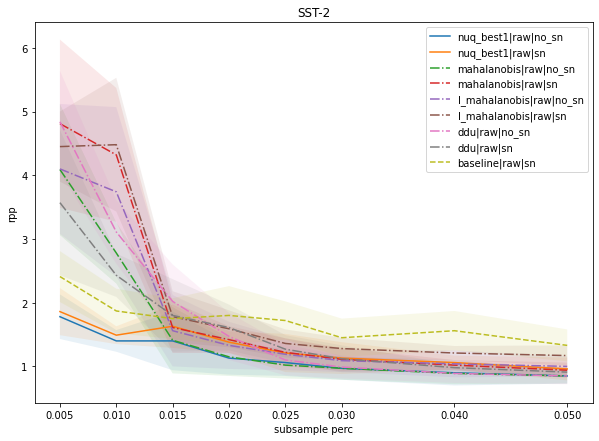

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

metric = 'rpp'
dataset = 'SST-2'

all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_nuq['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = table_nuq.iloc[table_nuq['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc.split('_')[1]))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    plt.plot(subsample_levels, curve_mean, label='|'.join(full_method.split('|')[:3]))
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)

all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_maha['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = table_maha.iloc[table_maha['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc.split('_')[1]))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    plt.plot(subsample_levels, curve_mean, '-.', label='|'.join(full_method.split('|')[:3]))
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    
all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_lmaha['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = table_lmaha.iloc[table_lmaha['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc.split('_')[1]))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    plt.plot(subsample_levels, curve_mean, '-.', label='|'.join(full_method.split('|')[:3]))
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
#'''

all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_ddu['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = table_ddu.iloc[table_ddu['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc.split('_')[1]))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    plt.plot(subsample_levels, curve_mean, '-.', label='|'.join(full_method.split('|')[:3]))
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    
all_methods = np.array(['|'.join(m.split('|')[:3]) for m in baselines_all.iloc[[4]]['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = baselines_all.iloc[baselines_all['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc.split('_')[1]))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    plt.plot(subsample_levels, curve_mean, '--', label='|'.join(full_method.split('|')[:3]))#, color = 'r', marker='-')
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    
plt.legend()
plt.xticks(subsample_levels)
plt.xlabel('subsample perc')
plt.ylabel(metric)
plt.title('SST-2')
plt.show()

In [17]:
def preproc_method(x):
    method = x.split('|')[0]
    sn = x.split('|')[-1]
    if method == 'mahalanobis' and not 'no_sn' in sn:
        return 'MD SN (ours)'
    elif method == 'mahalanobis':
        return 'MD'
    
    elif method == 'l_mahalanobis' and not 'no_sn' in sn:
        return 'L-MD SN (ours)'
    elif method == 'l_mahalanobis':
        return 'L-MD'
    
    elif method == 'mc_mahalanobis' and not 'no_sn' in sn:
        return 'SMD SN (ours)'
    elif method == 'mc_mahalanobis':
        return 'SMD'
    elif method == 'nuq' and not 'no_sn' in sn:
        return 'NUQ SN'
    elif method == 'nuq':
        return 'NUQ'
    
    elif method == 'decomposing_md' and not 'no_sn' in sn:
        return 'Decomposing SN'
    elif method == 'decomposing_md':
        return 'Decomposing'
    
    elif method == 'nuq_best1' and not 'no_sn' in sn:
        return 'NUQ SN'
    elif method == 'nuq_best1':
        return 'NUQ'
    
    elif method == 'l_nuq' and not 'no_sn' in sn:
        return 'L-NUQ SN'
    elif method == 'l_nuq':
        return 'L-NUQ'
    
    elif method == 'ddu' and not 'no_sn' in sn:
        return 'DDU SN'
    elif method == 'ddu':
        return 'DDU'
    
    elif method == 'ddu' and not 'no_sn' in sn:
        return 'DDU SN'
    elif method == 'ddu':
        return 'DDU'
    
    elif method == 'ddu_maha' and not 'no_sn' in sn:
        return 'DDU Maha SN'
    elif method == 'ddu_maha':
        return 'DDU Maha'
    
    elif 'ddpp_dpp' in method:
        return 'DDPP (+DPP) (ours)'
    elif 'ddpp_ood' in method:
        return 'DDPP (+OOD) (ours)'
    elif 'mc_all' in method:
        return 'MC dropout'
    elif 'Deep' in method:
        return 'Deep Ensemble'
    elif 'baseline|raw_no_sn' in x:
        return 'SR (baseline)'
    elif 'baseline' in x and not 'no_sn' in x:
        return 'SR SN'
    return 'SR'

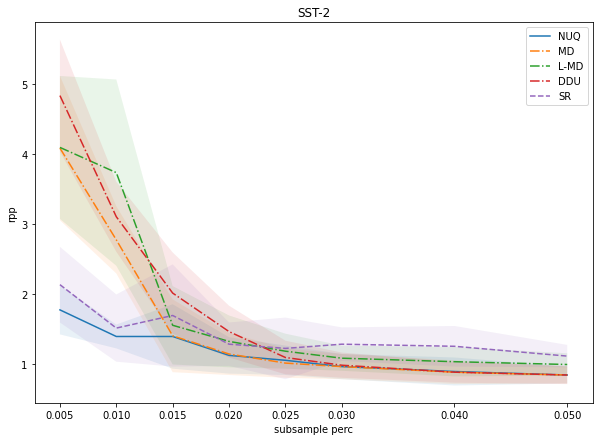

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

metric = 'rpp'
dataset = 'SST-2'

all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_nuq['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = table_nuq.iloc[table_nuq['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc.split('_')[1]))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    plt.plot(subsample_levels, curve_mean, label=preproc_method('|'.join(full_method.split('|')[:3])))
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)

all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_maha['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = table_maha.iloc[table_maha['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc.split('_')[1]))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    plt.plot(subsample_levels, curve_mean, '-.', label=preproc_method('|'.join(full_method.split('|')[:3])))
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    
    all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_lmaha['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = table_lmaha.iloc[table_lmaha['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc.split('_')[1]))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    plt.plot(subsample_levels, curve_mean, '-.', label=preproc_method('|'.join(full_method.split('|')[:3])))
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
#'''

all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_ddu['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = table_ddu.iloc[table_ddu['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc.split('_')[1]))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    plt.plot(subsample_levels, curve_mean, '-.', label=preproc_method('|'.join(full_method.split('|')[:3])))
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)

    
all_methods = np.array(['|'.join(m.split('|')[:3]) for m in baselines_all.iloc[[-1]]['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = baselines_all.iloc[baselines_all['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc.split('_')[1]))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    plt.plot(subsample_levels, curve_mean, '--', label=preproc_method('|'.join(full_method.split('|')[:3])))#, color = 'r', marker='-')
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    
plt.legend()
plt.xticks(subsample_levels)
plt.xlabel('subsample perc')
plt.ylabel(metric)
plt.title('SST-2')
plt.show()

In [21]:
import os 
    
def choose_agg_func(method):
    agg_methods = {
        "bald": bald,
        "sampled_max_prob": sampled_max_prob,
        "variance": probability_variance,
    }
    if method=='nuq' or method=='nuq_best' or method=='nuq_best1':
        nuq_aleatoric = lambda x: np.squeeze(x[0], axis=-1)
        nuq_epistemic = lambda x: np.squeeze(x[1], axis=-1)
        nuq_total = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {
            "nuq_aleatoric": nuq_aleatoric,
            "nuq_epistemic": nuq_epistemic,
            "nuq_total": nuq_total,
        }
    elif method=='ddu' or method=='ddu_maha':
        ddu = lambda x: -np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"ddu": ddu}
    elif method=='mahalanobis':
        maha_dist = lambda x: np.squeeze(x[0], axis=-1)
        agg_methods = {"mahalanobis_distance": maha_dist}
    elif method=='l_mahalanobis':
        maha_dist = lambda x: np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"l_mahalanobis_distance": maha_dist}
    elif method=='mc_mahalanobis':
        sm_maha_dist = lambda x: np.squeeze(x[:, 1:], axis=-1).max(1)
        agg_methods = {"sampled_mahalanobis_distance": sm_maha_dist}
    return agg_methods

    
metric_types=['rejection-curve-auc', "rcc-auc", 'rpp']
methods = ['mahalanobis', 'l_mahalanobis', 'nuq_best1', 'ddu']
regs = ['raw']
spectralnorm = ['sn', 'no_sn']
dataset_names = ['MRPC']
dataset_fnames = ['mrpc']
names = []
tables = []
baselines = []
subsample_percs = ['0.0_0.01', '0.0_0.02', '0.0_0.03', '0.0_0.04', '0.0_0.05', '0.0_0.06', '0.0_0.07', '0.0_0.08', '0.0_0.09', '0.0_0.1', '0.0_0.15', '0.0_0.2', '0.0_0.25', '0.0_0.3']
for method in methods:
    for reg in regs:
        for sn in spectralnorm:
            for subsample_perc in subsample_percs:
                run_dirs = []
                name_sn = ''
                names = [f'{method}|{reg}|{sn}|{subsample_perc}']
                for name in dataset_fnames:
                    model_series_dir = f'../../workdir/run_glue_for_model_series/electra_{reg}_{sn}/{name}/{subsample_perc}/{method}'
                    run_dirs.append([model_series_dir])
                agg_func = choose_agg_func(method)
                try:
                    res_df = collect_datasets(run_dirs, names, dataset_names, metric_types=metric_types, baselines={}, methods=agg_func)
                    baselines.append(res_df.iloc[-1:])
                    tables.append(res_df.iloc[:-1])
                    print(model_series_dir)
                except:
                    print('pass')
                    pass

pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
../../workdir/run_glue_for_model_series/electra_raw_no_sn/mrpc/0.0_0.01/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/mrpc/0.0_0.02/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/mrpc/0.0_0.03/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/mrpc/0.0_0.04/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/mrpc/0.0_0.05/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/mrpc/0.0_0.06/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/mrpc/0.0_0.07/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/mrpc/0.0_0.08/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/mrpc/0.0_0.09/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/mrpc/0.0_0.1/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/mrpc/0.0_0.15/mahalanobis
../../w

In [22]:
baselines_all = pd.concat([pd.concat(baselines)]).reset_index()
table_all = pd.concat([pd.concat(tables)]).reset_index()

In [23]:
table_nuq = table_all[(table_all['UE Score'] == 'nuq_aleatoric')].reset_index(drop=True)
table_maha = table_all[(table_all['UE Score'] == 'mahalanobis_distance')].reset_index(drop=True)
table_lmaha = table_all[(table_all['UE Score'] == 'l_mahalanobis_distance')].reset_index(drop=True)
table_ddu = table_all[(table_all['UE Score'] == 'ddu')].reset_index(drop=True)

In [24]:
subsample_percs = ['0.0_0.01', '0.0_0.02', '0.0_0.03', '0.0_0.04', '0.0_0.05', '0.0_0.06', '0.0_0.07', '0.0_0.08', '0.0_0.09', '0.0_0.1', '0.0_0.15', '0.0_0.2', '0.0_0.25', '0.0_0.3']

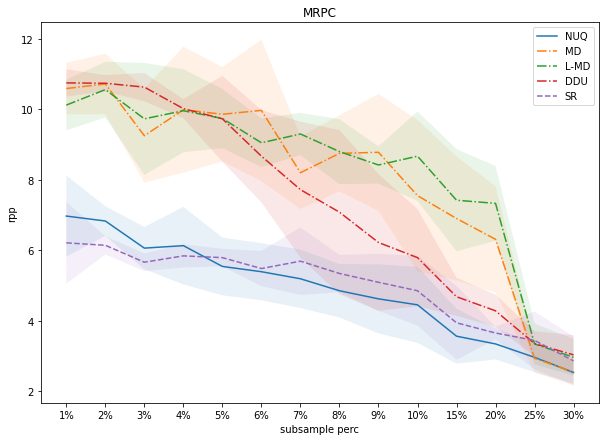

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

metric = 'rpp'
dataset = 'MRPC'

all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_nuq['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = table_nuq.iloc[table_nuq['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc.split('_')[1]))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
    plt.plot(subsample_levels, curve_mean, label=preproc_method('|'.join(full_method.split('|')[:3])))
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
  
#'''
all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_maha['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = table_maha.iloc[table_maha['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc.split('_')[1]))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
    plt.plot(subsample_levels, curve_mean, '-.', label=preproc_method('|'.join(full_method.split('|')[:3])))
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    
all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_lmaha['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = table_lmaha.iloc[table_lmaha['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc.split('_')[1]))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
    plt.plot(subsample_levels, curve_mean, '-.', label=preproc_method('|'.join(full_method.split('|')[:3])))
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
#'''

all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_ddu['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = table_ddu.iloc[table_ddu['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc.split('_')[1]))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
    plt.plot(subsample_levels, curve_mean, '-.', label=preproc_method('|'.join(full_method.split('|')[:3])))
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    
all_methods = np.array(['|'.join(m.split('|')[:3]) for m in baselines_all.iloc[[-1]]['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = baselines_all.iloc[baselines_all['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc.split('_')[1]))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
    plt.plot(subsample_levels, curve_mean, '--', label=preproc_method('|'.join(full_method.split('|')[:3])))#, color = 'r', marker='-')
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    
plt.legend()
plt.xticks(subsample_levels)
plt.xlabel('subsample perc')
plt.ylabel(metric)
plt.title('MRPC')
plt.show()

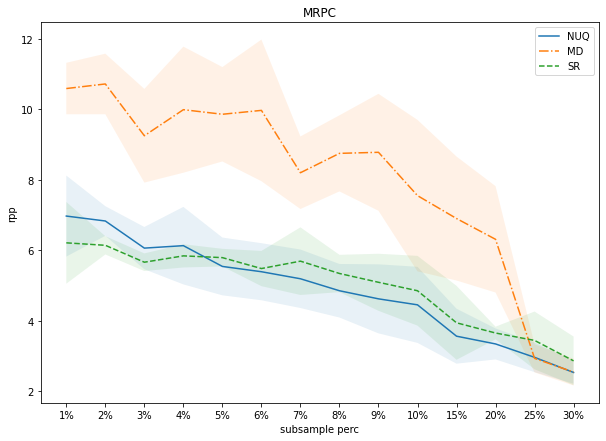

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

metric = 'rpp'
dataset = 'MRPC'

all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_nuq['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = table_nuq.iloc[table_nuq['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc.split('_')[1]))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
    plt.plot(subsample_levels, curve_mean, label=preproc_method('|'.join(full_method.split('|')[:3])))
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
  
#'''
all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_maha['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = table_maha.iloc[table_maha['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc.split('_')[1]))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
    plt.plot(subsample_levels, curve_mean, '-.', label=preproc_method('|'.join(full_method.split('|')[:3])))
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    
all_methods = np.array(['|'.join(m.split('|')[:3]) for m in baselines_all.iloc[[-1]]['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = baselines_all.iloc[baselines_all['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc.split('_')[1]))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
    plt.plot(subsample_levels, curve_mean, '--', label=preproc_method('|'.join(full_method.split('|')[:3])))#, color = 'r', marker='-')
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    
plt.legend()
plt.xticks(subsample_levels)
plt.xlabel('subsample perc')
plt.ylabel(metric)
plt.title('MRPC')
plt.show()

In [136]:
subsample_percs = ['0.0_0.01', '0.0_0.02', '0.0_0.05']

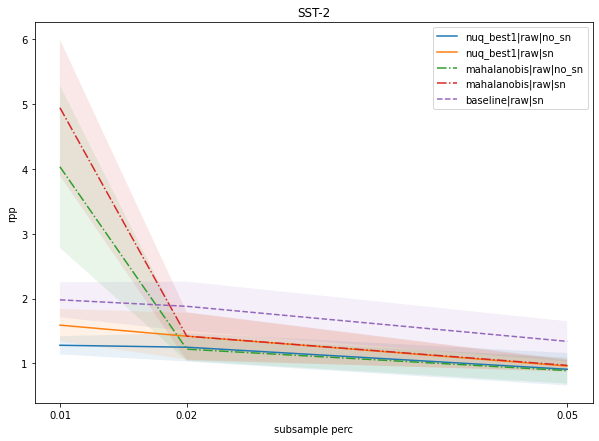

In [137]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

metric = 'rpp'
dataset = 'SST-2'

all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_nuq['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = table_nuq.iloc[table_nuq['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc.split('_')[1]))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    plt.plot(subsample_levels, curve_mean, label='|'.join(full_method.split('|')[:3]))
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    
all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_maha['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = table_maha.iloc[table_maha['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc.split('_')[1]))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    plt.plot(subsample_levels, curve_mean, '-.', label='|'.join(full_method.split('|')[:3]))
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    
all_methods = np.array(['|'.join(m.split('|')[:3]) for m in baselines_all.iloc[[4]]['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = baselines_all.iloc[baselines_all['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc.split('_')[1]))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    plt.plot(subsample_levels, curve_mean, '--', label='|'.join(full_method.split('|')[:3]))#, color = 'r', marker='-')
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    
plt.legend()
plt.xticks(subsample_levels)
plt.xlabel('subsample perc')
plt.ylabel(metric)
plt.title('SST-2')
plt.show()

# Subsample datasets for OOD

In [2]:
import sys
sys.path.insert(0,'..')

import yaml
import os
from yaml import Loader as Loader
from pathlib import Path
import pandas as pd
import numpy as np
import json
from sklearn.metrics import roc_auc_score

from analyze_results import (
    extract_result,
    aggregate_runs,
    from_model_outputs_calc_rcc_auc,
    format_results2,
    improvement_over_baseline,
    from_model_outputs_calc_pr_auc,
    from_model_outputs_calc_rpp,
    from_model_outputs_calc_roc_auc,
    from_model_outputs_calc_arc_auc,
    from_model_outputs_calc_f1_score
)

from utils.utils_wandb import init_wandb, wandb
from ue4nlp.ue_scores import *

In [3]:
def choose_metric(metric_type):
    if metric_type  == "rejection-curve-auc":
        return metric_type
    elif metric_type  == "roc-auc":
        return metric_type
    elif metric_type == "rcc-auc":
        return from_model_outputs_calc_rcc_auc
    elif metric_type == "rpp":
        return from_model_outputs_calc_rpp
    elif metric_type == "pr-auc":
        return from_model_outputs_calc_pr_auc
    elif metric_type == "f1-score":
        return from_model_outputs_calc_f1_score
    else:
        raise ValueError("Wrong metric type!")
        
def get_one_table(runs_dir, metric_types=["rejection-curve-auc", "roc-auc", "pr-auc"], baseline=None, methods=None):
    default_methods = {
        "bald": bald,
        "sampled_max_prob": sampled_max_prob,
        "variance": probability_variance,
    }
    
    if methods is None:
        methods = default_methods

    table = []
    for metric_type in metric_types:
        metric = choose_metric(metric_type=metric_type)

        agg_res = aggregate_runs(
            runs_dir, methods=methods, metric=metric, oos=True
        )
        if agg_res.empty:
            print("Broken\n")
            continue

        if metric_type == "rcc-auc":
            final_score = format_results2(agg_res, percents=False)
        elif metric_type == "rpp":
            final_score = format_results2(agg_res, percents=True)
        elif metric_type == "accuracy":
            final_score = format_results2(agg_res, percents=True)
        else:
            final_score = improvement_over_baseline(agg_res, baseline_col="max_prob", baseline=baseline, metric=metric_type, percents=True, subtract=False)
        table.append(final_score)
    res_table = pd.concat(table, axis=1)
    res_table.columns = metric_types
    # fix for rcc-auc and rpp
    if 'baseline (max_prob)' not in res_table.index:
        res_table.loc['baseline (max_prob)'] = 0
    try:
        res_table = res_table.drop(['max_prob', 'count'])
    except:
        res_table = res_table.drop(['count'])
    return res_table


def collect_tables(run_dirs, names, metric_types=["rejection-curve-auc", "roc-auc", "rcc-auc", "pr-auc", "rpp"], baseline=None, methods=None):
    all_tables = []
    for run_dir, name in zip(run_dirs, names):
        buf_table = get_one_table(run_dir, metric_types, baseline, methods)
        #print(buf_table)
        # add name to index
        indices = [(name, ind) for ind in list(buf_table.index)]
        baseline_name = 'baseline|'+'|'.join(name.split('|')[1:])
        buf_table.loc[baseline_name] = buf_table.loc['baseline (max_prob)']
        # add reindex
        indices = indices + [(baseline_name, 'max_prob')]
        
        index = pd.MultiIndex.from_tuples(indices, names=['Method', 'UE Score'])
        buf_table.index = index
        buf_table.drop((name, 'baseline (max_prob)'), inplace=True)
        # add buf_table to final_table
        all_tables.append(buf_table)
    return pd.concat(all_tables)


def collect_datasets(runs_dirs, names, dataset_names, metric_types=["rejection-curve-auc", "roc-auc", "rcc-auc", "pr-auc", "rpp"], baselines={}, methods=None):
    all_tables = []
    for run_dir, dataset_name in zip(runs_dirs, dataset_names):
        try:
            dataset_table = collect_tables(run_dir, names, metric_types, baselines.get(dataset_name, None), methods=methods)
            columns = pd.MultiIndex.from_tuples([(dataset_name, ind) for ind in list(dataset_table.columns)])
            dataset_table.columns = columns
            all_tables.append(dataset_table)
        except:
            print(f'empty dir {run_dir}')
    return pd.concat(all_tables, axis=1)

In [4]:
import os 
def choose_agg_func(method):
    agg_methods = {
        "bald": bald,
        "sampled_max_prob": sampled_max_prob,
        "variance": probability_variance,
    }
    if method=='nuq' or method=='nuq_best' or method=='nuq_best1':
        nuq_aleatoric = lambda x: np.squeeze(x[0], axis=-1)
        nuq_epistemic = lambda x: np.squeeze(x[1], axis=-1)
        nuq_total = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {
            "nuq_aleatoric": nuq_aleatoric,
            "nuq_epistemic": nuq_epistemic,
            "nuq_total": nuq_total,
        }
    elif method=='decomposing_md':
        disc_md = lambda x: np.squeeze(x[0], axis=-1)
        nondisc_md = lambda x: np.squeeze(x[1], axis=-1)
        sum_md = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {"disc_md": disc_md, 
                       'nondisc_md': nondisc_md,
                       'disc+nondisc_md': sum_md}
    elif method=='mahalanobis':
        maha_dist = lambda x: np.squeeze(x[0], axis=-1)
        rel_maha_dist = lambda x: np.squeeze(x[1], axis=-1)
        marg_maha_dist = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {"mahalanobis_distance": maha_dist,
                       "relative_mahalanobis_distance": rel_maha_dist,
                       "marginal_mahalanobis_distance": marg_maha_dist}
    elif method=='l_nuq':
        nuq_aleatoric = lambda x: np.squeeze(x[0], axis=-1)
        nuq_epistemic = lambda x: np.squeeze(x[1], axis=-1)
        nuq_total = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {
            "l_nuq_aleatoric": nuq_aleatoric,
            "l_nuq_epistemic": nuq_epistemic,
            "l_nuq_total": nuq_total,
        }
    elif method=='ddu' or method=='ddu_maha':
        ddu = lambda x: -np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"ddu": ddu}
    elif method=='l_mahalanobis':
        ddu = lambda x: np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"l_mahalanobis_distance": ddu}
        
    elif method=='sngp':
        sngp = lambda x: np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"sngp": sngp}
    elif method=='mc_mahalanobis':
        sm_maha_dist = lambda x: np.squeeze(x[:, 1:], axis=-1).max(1)
        agg_methods = {"sampled_mahalanobis_distance": sm_maha_dist}
    return agg_methods
metric_types=["roc-auc", 'pr-auc']

methods = ['l_nuq', 'nuq', 'mahalanobis', 'l_mahalanobis', 'ddu']
regs = ['raw']#, 'reg', 'metric']
spectralnorm = ['no_sn']#, 'no_sn']
dataset_names = ['CLINC']#, 'ROSTD']
dataset_fnames = ['clinc']#, 'rostd']
subsample_percs = [0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.3]

names = []
tables = []
baselines = []
for method in methods:
    for reg in regs:
        for sn in spectralnorm:
            for subsample_perc in subsample_percs:
                run_dirs = []
                name_sn = ''
                names = [f'{method}|{reg}|{sn}|{subsample_perc}']
                for name in dataset_fnames:
                    model_series_dir = f'../../workdir/run_glue_for_model_series/electra_{reg}_{sn}/{name}/{subsample_perc}/{method}'
                    print(model_series_dir)
                    run_dirs.append([model_series_dir])
                    agg_func = choose_agg_func(method)
                try:
                    res_df = collect_datasets(run_dirs, names, dataset_names, metric_types=metric_types, baselines={}, methods=agg_func)
                    baselines.append(res_df.iloc[-1:])
                    tables.append(res_df.iloc[:-1])
                except:
                    print('pass')
                    pass

../../workdir/run_glue_for_model_series/electra_raw_no_sn/clinc/0.01/l_nuq
empty dir ['../../workdir/run_glue_for_model_series/electra_raw_no_sn/clinc/0.01/l_nuq']
pass
../../workdir/run_glue_for_model_series/electra_raw_no_sn/clinc/0.02/l_nuq
empty dir ['../../workdir/run_glue_for_model_series/electra_raw_no_sn/clinc/0.02/l_nuq']
pass
../../workdir/run_glue_for_model_series/electra_raw_no_sn/clinc/0.05/l_nuq
empty dir ['../../workdir/run_glue_for_model_series/electra_raw_no_sn/clinc/0.05/l_nuq']
pass
../../workdir/run_glue_for_model_series/electra_raw_no_sn/clinc/0.1/l_nuq
empty dir ['../../workdir/run_glue_for_model_series/electra_raw_no_sn/clinc/0.1/l_nuq']
pass
../../workdir/run_glue_for_model_series/electra_raw_no_sn/clinc/0.15/l_nuq
empty dir ['../../workdir/run_glue_for_model_series/electra_raw_no_sn/clinc/0.15/l_nuq']
pass
../../workdir/run_glue_for_model_series/electra_raw_no_sn/clinc/0.2/l_nuq
empty dir ['../../workdir/run_glue_for_model_series/electra_raw_no_sn/clinc/0.2/l_n

In [20]:
baselines_all = pd.concat([pd.concat(baselines)]).reset_index()
table_all = pd.concat([pd.concat(tables)]).reset_index()

table_lnuq = table_all[(table_all['UE Score'] == 'l_nuq_epistemic')].reset_index(drop=True)
table_nuq = table_all[(table_all['UE Score'] == 'nuq_epistemic')].reset_index(drop=True)
table_maha = table_all[(table_all['UE Score'] == 'mahalanobis_distance')].reset_index(drop=True)
table_lmaha = table_all[(table_all['UE Score'] == 'l_mahalanobis_distance')].reset_index(drop=True)
table_ddu = table_all[(table_all['UE Score'] == 'ddu')].reset_index(drop=True)

In [21]:
subsample_percs = [0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.3]

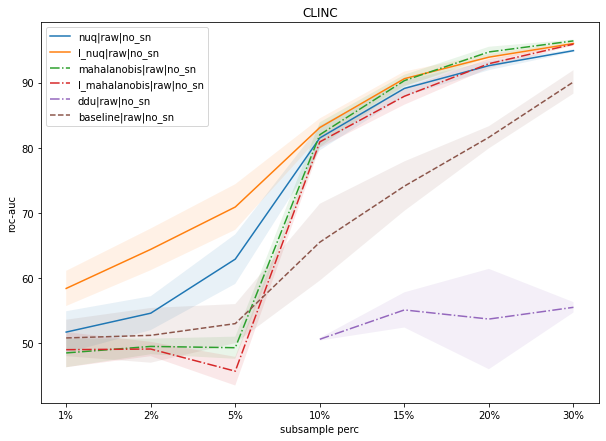

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

metric = 'roc-auc'
dataset = 'CLINC'

all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_nuq['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = table_nuq.iloc[table_nuq['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
    plt.plot(subsample_levels, curve_mean, label='|'.join(full_method.split('|')[:3]))
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    

    
all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_lnuq['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = table_lnuq.iloc[table_lnuq['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
    plt.plot(subsample_levels, curve_mean, label='|'.join(full_method.split('|')[:3]))
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)

all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_maha['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = table_maha.iloc[table_maha['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
    plt.plot(subsample_levels, curve_mean, '-.', label='|'.join(full_method.split('|')[:3]))
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    
all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_lmaha['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = table_lmaha.iloc[table_lmaha['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
    plt.plot(subsample_levels, curve_mean, '-.', label='|'.join(full_method.split('|')[:3]))
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    
all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_ddu['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = table_ddu.iloc[table_ddu['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
    plt.plot(subsample_levels, curve_mean, '-.', label='|'.join(full_method.split('|')[:3]))
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)

all_methods = np.array(['|'.join(m.split('|')[:3]) for m in baselines_all.iloc[[0]]['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = baselines_all.iloc[baselines_all['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
    plt.plot(subsample_levels, curve_mean, '--', label='|'.join(full_method.split('|')[:3]))#, color = 'r', marker='-')
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    
plt.legend()
plt.xticks(subsample_levels)
plt.xlabel('subsample perc')
plt.ylabel(metric)
plt.title(dataset)
plt.show()

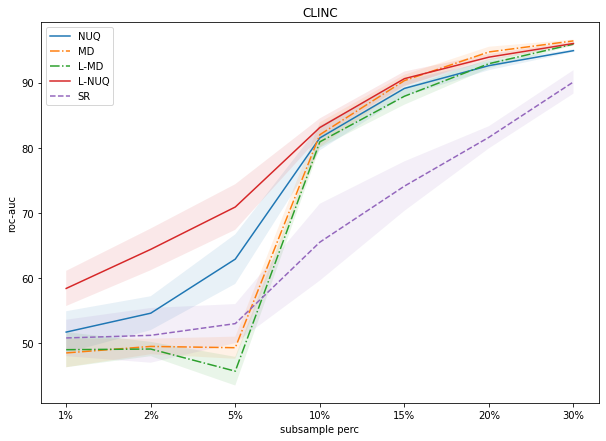

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

metric = 'roc-auc'
dataset = 'CLINC'

all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_nuq['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = table_nuq.iloc[table_nuq['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
    plt.plot(subsample_levels, curve_mean, label=preproc_method('|'.join(full_method.split('|')[:3])))
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    

all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_maha['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = table_maha.iloc[table_maha['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
    plt.plot(subsample_levels, curve_mean, '-.', label=preproc_method('|'.join(full_method.split('|')[:3])))
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    
all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_lmaha['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = table_lmaha.iloc[table_lmaha['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
    plt.plot(subsample_levels, curve_mean, '-.', label=preproc_method('|'.join(full_method.split('|')[:3])))
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    
    
    
all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_lnuq['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = table_lnuq.iloc[table_lnuq['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
    plt.plot(subsample_levels, curve_mean, label=preproc_method('|'.join(full_method.split('|')[:3])))
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)

    

all_methods = np.array(['|'.join(m.split('|')[:3]) for m in baselines_all.iloc[[0]]['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = baselines_all.iloc[baselines_all['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
    plt.plot(subsample_levels, curve_mean, '--', label=preproc_method('|'.join(full_method.split('|')[:3])))#, color = 'r', marker='-')
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    
plt.legend()
plt.xticks(subsample_levels)
plt.xlabel('subsample perc')
plt.ylabel(metric)
plt.title(dataset)
plt.show()

In [10]:
import os 
def choose_agg_func(method):
    agg_methods = {
        "bald": bald,
        "sampled_max_prob": sampled_max_prob,
        "variance": probability_variance,
    }
    if method=='nuq' or method=='nuq_best' or method=='nuq_best1':
        nuq_aleatoric = lambda x: np.squeeze(x[0], axis=-1)
        nuq_epistemic = lambda x: np.squeeze(x[1], axis=-1)
        nuq_total = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {
            "nuq_aleatoric": nuq_aleatoric,
            "nuq_epistemic": nuq_epistemic,
            "nuq_total": nuq_total,
        }
    elif method=='decomposing_md':
        disc_md = lambda x: np.squeeze(x[0], axis=-1)
        nondisc_md = lambda x: np.squeeze(x[1], axis=-1)
        sum_md = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {"disc_md": disc_md, 
                       'nondisc_md': nondisc_md,
                       'disc+nondisc_md': sum_md}
    elif method=='mahalanobis':
        maha_dist = lambda x: np.squeeze(x[0], axis=-1)
        rel_maha_dist = lambda x: np.squeeze(x[1], axis=-1)
        marg_maha_dist = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {"mahalanobis_distance": maha_dist,
                       "relative_mahalanobis_distance": rel_maha_dist,
                       "marginal_mahalanobis_distance": marg_maha_dist}
    elif method=='l_nuq':
        nuq_aleatoric = lambda x: np.squeeze(x[0], axis=-1)
        nuq_epistemic = lambda x: np.squeeze(x[1], axis=-1)
        nuq_total = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {
            "l_nuq_aleatoric": nuq_aleatoric,
            "l_nuq_epistemic": nuq_epistemic,
            "l_nuq_total": nuq_total,
        }       
    elif method=='ddu' or method=='ddu_maha':
        ddu = lambda x: -np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"ddu": ddu}
    elif method=='l_mahalanobis':
        ddu = lambda x: np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"l_mahalanobis_distance": ddu}
    elif method=='sngp':
        sngp = lambda x: np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"sngp": sngp}
    elif method=='mc_mahalanobis':
        sm_maha_dist = lambda x: np.squeeze(x[:, 1:], axis=-1).max(1)
        agg_methods = {"sampled_mahalanobis_distance": sm_maha_dist}
    return agg_methods
metric_types=["roc-auc", 'pr-auc']

methods = ['nuq', 'mahalanobis', 'l_mahalanobis', 'l_nuq', 'ddu']
regs = ['raw']#, 'reg', 'metric']
spectralnorm = ['no_sn']#, 'no_sn']
dataset_names = ['ROSTD']
dataset_fnames = ['rostd']
subsample_percs = [0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.3]

names = []
tables = []
baselines = []
for method in methods:
    for reg in regs:
        for sn in spectralnorm:
            for subsample_perc in subsample_percs:
                run_dirs = []
                name_sn = ''
                names = [f'{method}|{reg}|{sn}|{subsample_perc}']
                for name in dataset_fnames:
                    model_series_dir = f'../../workdir/run_glue_for_model_series/electra_{reg}_{sn}/{name}/{subsample_perc}/{method}'
                    print(model_series_dir)
                    run_dirs.append([model_series_dir])
                    agg_func = choose_agg_func(method)
                try:
                    res_df = collect_datasets(run_dirs, names, dataset_names, metric_types=metric_types, baselines={}, methods=agg_func)
                    baselines.append(res_df.iloc[-1:])
                    tables.append(res_df.iloc[:-1])
                except:
                    print('pass')
                    pass

../../workdir/run_glue_for_model_series/electra_raw_no_sn/rostd/0.01/nuq
../../workdir/run_glue_for_model_series/electra_raw_no_sn/rostd/0.02/nuq
../../workdir/run_glue_for_model_series/electra_raw_no_sn/rostd/0.05/nuq
../../workdir/run_glue_for_model_series/electra_raw_no_sn/rostd/0.1/nuq
../../workdir/run_glue_for_model_series/electra_raw_no_sn/rostd/0.15/nuq
../../workdir/run_glue_for_model_series/electra_raw_no_sn/rostd/0.2/nuq
../../workdir/run_glue_for_model_series/electra_raw_no_sn/rostd/0.3/nuq
../../workdir/run_glue_for_model_series/electra_raw_no_sn/rostd/0.01/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/rostd/0.02/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/rostd/0.05/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/rostd/0.1/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/rostd/0.15/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/rostd/0.2/mahalanobis
../../wo

In [11]:
baselines_all = pd.concat([pd.concat(baselines)]).reset_index()
table_all = pd.concat([pd.concat(tables)]).reset_index()

table_nuq = table_all[(table_all['UE Score'] == 'nuq_epistemic')].reset_index(drop=True)
table_maha = table_all[(table_all['UE Score'] == 'mahalanobis_distance')].reset_index(drop=True)
table_lmaha = table_all[(table_all['UE Score'] == 'l_mahalanobis_distance')].reset_index(drop=True)
table_lnuq = table_all[(table_all['UE Score'] == 'l_nuq_epistemic')].reset_index(drop=True)
table_ddu = table_all[(table_all['UE Score'] == 'ddu')].reset_index(drop=True)

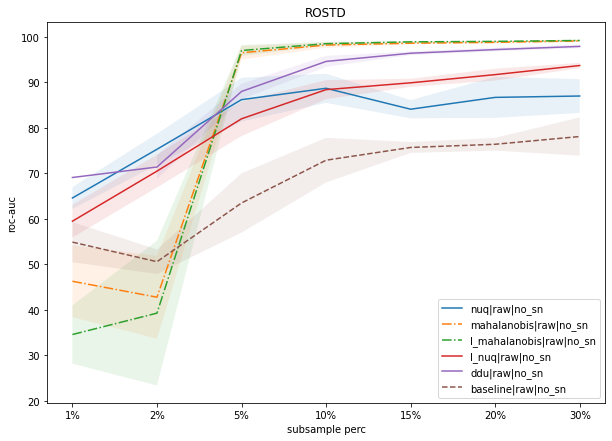

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

metric = 'roc-auc'
dataset = 'ROSTD'

all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_nuq['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = table_nuq.iloc[table_nuq['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
    plt.plot(subsample_levels, curve_mean, label='|'.join(full_method.split('|')[:3]))
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    

all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_maha['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = table_maha.iloc[table_maha['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
    plt.plot(subsample_levels, curve_mean, '-.', label='|'.join(full_method.split('|')[:3]))
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    
all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_lmaha['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = table_lmaha.iloc[table_lmaha['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
    plt.plot(subsample_levels, curve_mean, '-.', label='|'.join(full_method.split('|')[:3]))
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    
all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_lnuq['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = table_lnuq.iloc[table_lnuq['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
    plt.plot(subsample_levels, curve_mean, label='|'.join(full_method.split('|')[:3]))
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    
all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_ddu['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = table_ddu.iloc[table_ddu['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
    plt.plot(subsample_levels, curve_mean, label='|'.join(full_method.split('|')[:3]))
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)

all_methods = np.array(['|'.join(m.split('|')[:3]) for m in baselines_all.iloc[[0]]['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = baselines_all.iloc[baselines_all['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
    plt.plot(subsample_levels, curve_mean, '--', label='|'.join(full_method.split('|')[:3]))#, color = 'r', marker='-')
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    
plt.legend()
plt.xticks(subsample_levels)
plt.xlabel('subsample perc')
plt.ylabel(metric)
plt.title(dataset)
plt.show()

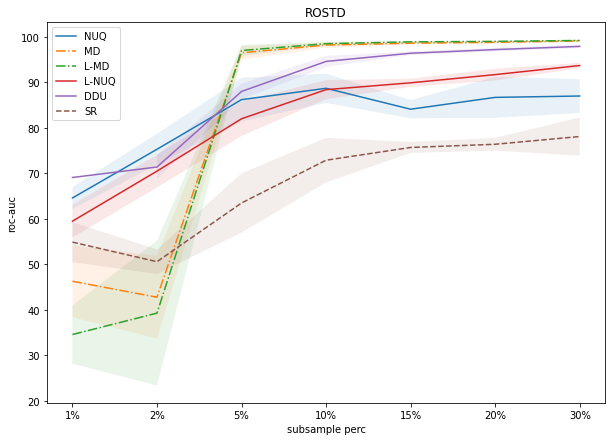

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

metric = 'roc-auc'
dataset = 'ROSTD'

all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_nuq['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = table_nuq.iloc[table_nuq['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
    plt.plot(subsample_levels, curve_mean, label=preproc_method('|'.join(full_method.split('|')[:3])))
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    

all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_maha['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = table_maha.iloc[table_maha['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
    plt.plot(subsample_levels, curve_mean, '-.', label=preproc_method('|'.join(full_method.split('|')[:3])))
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    
    
all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_lmaha['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = table_lmaha.iloc[table_lmaha['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
    plt.plot(subsample_levels, curve_mean, '-.', label=preproc_method('|'.join(full_method.split('|')[:3])))
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    
    all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_lnuq['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = table_lnuq.iloc[table_lnuq['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
    plt.plot(subsample_levels, curve_mean, label=preproc_method('|'.join(full_method.split('|')[:3])))
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    
all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_ddu['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = table_ddu.iloc[table_ddu['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
    plt.plot(subsample_levels, curve_mean, label=preproc_method('|'.join(full_method.split('|')[:3])))
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)

all_methods = np.array(['|'.join(m.split('|')[:3]) for m in baselines_all.iloc[[0]]['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    subsample_levels = []
    for subsample_perc in subsample_percs:
        full_method = method + f'|{subsample_perc}'
        row = baselines_all.iloc[baselines_all['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        subsample_levels.append(float(subsample_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
    plt.plot(subsample_levels, curve_mean, '--', label=preproc_method('|'.join(full_method.split('|')[:3])))#, color = 'r', marker='-')
    plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    
plt.legend()
plt.xticks(subsample_levels)
plt.xlabel('subsample perc')
plt.ylabel(metric)
plt.title(dataset)
plt.show()

## New benchmark

In [18]:
import os 

def choose_agg_func(method):
    agg_methods = {
        "bald": bald,
        "sampled_max_prob": sampled_max_prob,
        "variance": probability_variance,
    }
    if method=='nuq' or method=='nuq_best' or method=='nuq_best1':
        nuq_aleatoric = lambda x: np.squeeze(x[0], axis=-1)
        nuq_epistemic = lambda x: np.squeeze(x[1], axis=-1)
        nuq_total = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {
            "nuq_aleatoric": nuq_aleatoric,
            "nuq_epistemic": nuq_epistemic,
            "nuq_total": nuq_total,
        }
    elif method=='l_nuq':
        nuq_aleatoric = lambda x: np.squeeze(x[0], axis=-1)
        nuq_epistemic = lambda x: np.squeeze(x[1], axis=-1)
        nuq_total = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {
            "l_nuq_aleatoric": nuq_aleatoric,
            "l_nuq_epistemic": nuq_epistemic,
            "l_nuq_total": nuq_total,
        }
    elif method=='decomposing_md':
        disc_md = lambda x: np.squeeze(x[0], axis=-1)
        nondisc_md = lambda x: np.squeeze(x[1], axis=-1)
        sum_md = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {"disc_md": disc_md, 
                       'nondisc_md': nondisc_md,
                       'disc+nondisc_md': sum_md}
    elif method=='mahalanobis':
        maha_dist = lambda x: np.squeeze(x[0], axis=-1)
        rel_maha_dist = lambda x: np.squeeze(x[1], axis=-1)
        marg_maha_dist = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {"mahalanobis_distance": maha_dist,
                       "relative_mahalanobis_distance": rel_maha_dist,
                       "marginal_mahalanobis_distance": marg_maha_dist}
    elif method=='l_mahalanobis':
        maha_dist = lambda x: np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"l_mahalanobis_distance": maha_dist}
    elif method=='ddu' or method=='ddu_maha':
        ddu = lambda x: -np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"ddu": ddu}
    elif method=='sngp':
        sngp = lambda x: np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"sngp": sngp}
    elif method=='mc_mahalanobis':
        sm_maha_dist = lambda x: np.squeeze(x[:, 1:], axis=-1).max(1)
        agg_methods = {"sampled_mahalanobis_distance": sm_maha_dist}
    return agg_methods
metric_types=["roc-auc"]#, 'pr-auc', 'f1-score', 'precision', 'recall']

methods = ['nuq', 'mahalanobis']
regs = ['raw']
spectralnorm = ['no_sn']
dataset_names = ['IMDB', 'TREC', 'WMT16', 'Amazon', 'MNLI', '20newsgroups', 'RTE']
dataset_fnames = ['imdb', 'trec', 'wmt16', 'amazon', 'mnli', 'newsgroup', 'rte']
subsample_percs = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3]#[0.005, 0.01, 0.015, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2, 0.3]
names = []
tables = []
baselines = []
for method in methods:
    for reg in regs:
        for sn in spectralnorm:
            for subsample_perc in subsample_percs:
                run_dirs = []
                name_sn = ''
                names = [f'{method}|{reg}|{sn}|{subsample_perc}']
                for name in dataset_fnames:
                    model_series_dir = f'../../workdir/run_tasks_for_model_series/electra_{reg}_{sn}/sst2/{subsample_perc}/{name}/{method}'
                    print(model_series_dir)
                    run_dirs.append([model_series_dir])
                agg_func = choose_agg_func(method)
                try:
                    res_df = collect_datasets(run_dirs, names, dataset_names, metric_types=metric_types, baselines={}, methods=agg_func)
                    baselines.append(res_df.iloc[-1:])
                    tables.append(res_df.iloc[:-1])
                except:
                    print('pass')
                    pass

../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/0.01/imdb/nuq
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/0.01/trec/nuq
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/0.01/wmt16/nuq
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/0.01/amazon/nuq
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/0.01/mnli/nuq
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/0.01/newsgroup/nuq
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/0.01/rte/nuq
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/0.02/imdb/nuq
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/0.02/trec/nuq
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/0.02/wmt16/nuq
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/0.02/amazon/nuq
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/0.02/mnli/nuq
../../workdir/run_tasks_for_model_series/electra_raw_n

In [22]:
baselines_all = pd.concat([pd.concat(baselines)]).reset_index()
table_all = pd.concat([pd.concat(tables)]).reset_index()

roc_auc_mean = table_all[table_all.columns[2:]].apply(lambda x: x.str.split('±').str[0].astype(float)).mean(axis=1)
roc_auc_std = table_all[table_all.columns[2:]].apply(lambda x: x.str.split('±').str[1].astype(float)).mean(axis=1)

table_all[('Mean',  'roc-auc')] = roc_auc_mean.round(2).astype(str)+'±'+roc_auc_std.round(2).astype(str)


roc_auc_mean = baselines_all[baselines_all.columns[2:]].apply(lambda x: x.str.split('±').str[0].astype(float)).mean(axis=1)
roc_auc_std = baselines_all[baselines_all.columns[2:]].apply(lambda x: x.str.split('±').str[1].astype(float)).mean(axis=1)

baselines_all[('Mean',  'roc-auc')] = roc_auc_mean.round(2).astype(str)+'±'+roc_auc_std.round(2).astype(str)

table_nuq = table_all[(table_all['UE Score'] == 'nuq_epistemic')].reset_index(drop=True)
table_maha = table_all[(table_all['UE Score'] == 'mahalanobis_distance')].reset_index(drop=True)
table_mahar = table_all[(table_all['UE Score'] == 'relative_mahalanobis_distance')].reset_index(drop=True)
table_maham = table_all[(table_all['UE Score'] == 'marginal_mahalanobis_distance')].reset_index(drop=True)

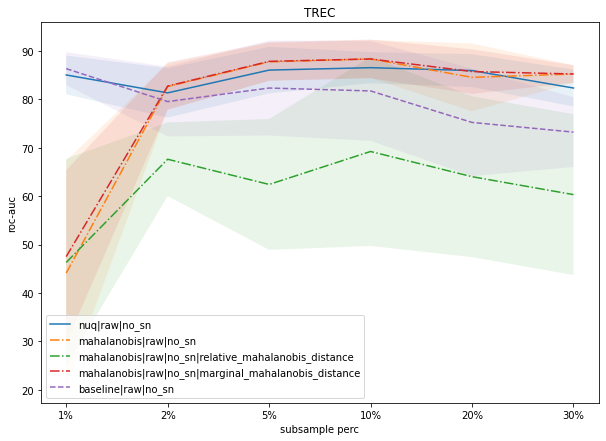

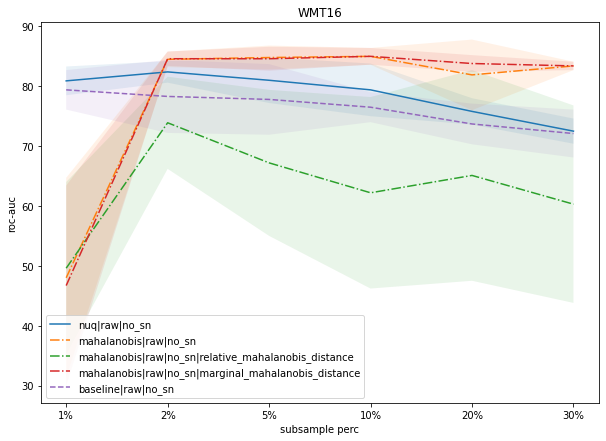

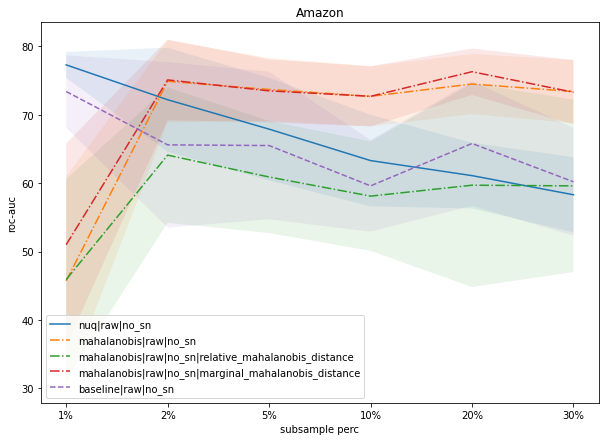

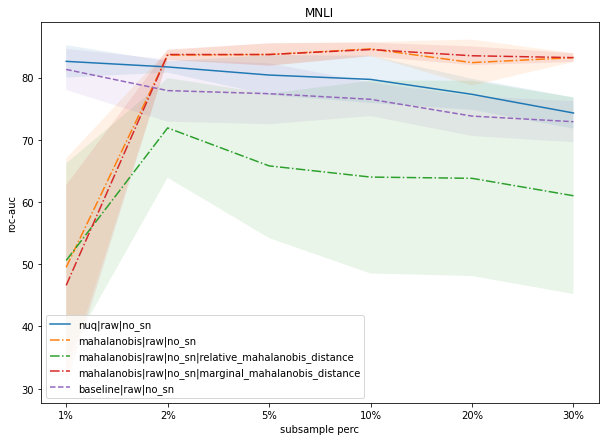

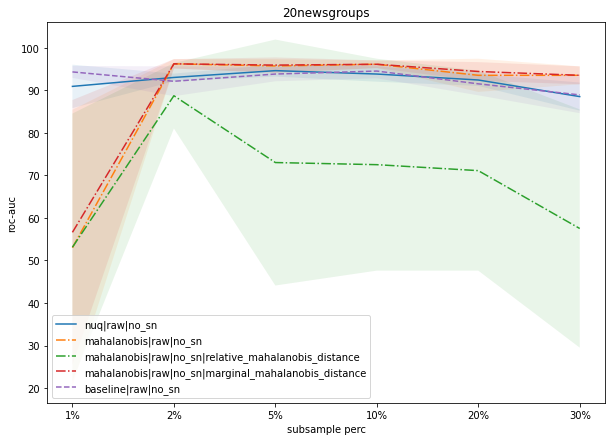

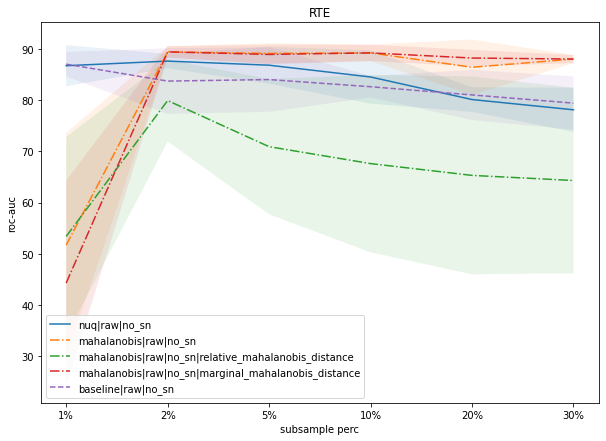

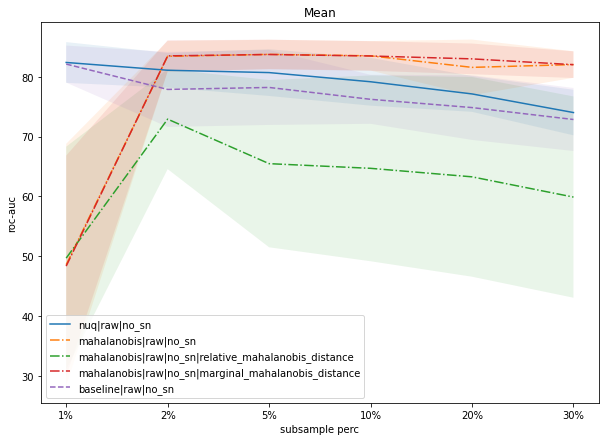

In [30]:
import matplotlib.pyplot as plt

for x in table_nuq.columns[3:]:
    plt.figure(figsize=(10, 7))

    metric = 'roc-auc'
    dataset = x[0]#'Mean'

    all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_nuq['Method'].values])
    for method in np.unique(all_methods):
        curve_mean = []
        curve_std = []
        subsample_levels = []
        for subsample_perc in subsample_percs:
            full_method = method + f'|{subsample_perc}'
            row = table_nuq.iloc[table_nuq['Method'].values == full_method]
            if not len(row):
                continue
            value = row[(dataset, metric)].values[0]
            curve_mean.append(float(value.split('±')[0]))
            curve_std.append(float(value.split('±')[1]))
            subsample_levels.append(float(subsample_perc))
        if len(curve_mean) < 2:
            continue
        curve_mean = np.array(curve_mean)
        curve_std = np.array(curve_std)
        subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
        plt.plot(subsample_levels, curve_mean, label='|'.join(full_method.split('|')[:3]))
        plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)

    try:
        all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_maha['Method'].values])
        for method in np.unique(all_methods):
            curve_mean = []
            curve_std = []
            subsample_levels = []
            for subsample_perc in subsample_percs:
                full_method = method + f'|{subsample_perc}'
                row = table_maha.iloc[table_maha['Method'].values == full_method]
                if not len(row):
                    continue
                value = row[(dataset, metric)].values[0]
                curve_mean.append(float(value.split('±')[0]))
                curve_std.append(float(value.split('±')[1]))
                subsample_levels.append(float(subsample_perc))
            if len(curve_mean) < 2:
                continue
            curve_mean = np.array(curve_mean)
            curve_std = np.array(curve_std)
            subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
            plt.plot(subsample_levels, curve_mean, '-.', label='|'.join(full_method.split('|')[:3]))
            plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    except:
        pass

    all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_mahar['Method'].values])
    for method in np.unique(all_methods):
        curve_mean = []
        curve_std = []
        subsample_levels = []
        for subsample_perc in subsample_percs:
            full_method = method + f'|{subsample_perc}'
            row = table_mahar.iloc[table_mahar['Method'].values == full_method]
            if not len(row):
                continue
            value = row[(dataset, metric)].values[0]
            curve_mean.append(float(value.split('±')[0]))
            curve_std.append(float(value.split('±')[1]))
            subsample_levels.append(float(subsample_perc))
        if len(curve_mean) < 2:
            continue
        curve_mean = np.array(curve_mean)
        curve_std = np.array(curve_std)
        subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
        plt.plot(subsample_levels, curve_mean, '-.', label='|'.join(full_method.split('|')[:3] + [row['UE Score'].values[0]]))
        plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)

    all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_maham['Method'].values])
    for method in np.unique(all_methods):
        curve_mean = []
        curve_std = []
        subsample_levels = []
        for subsample_perc in subsample_percs:
            full_method = method + f'|{subsample_perc}'
            row = table_maham.iloc[table_maham['Method'].values == full_method]
            if not len(row):
                continue
            value = row[(dataset, metric)].values[0]
            curve_mean.append(float(value.split('±')[0]))
            curve_std.append(float(value.split('±')[1]))
            subsample_levels.append(float(subsample_perc))
        if len(curve_mean) < 2:
            continue
        curve_mean = np.array(curve_mean)
        curve_std = np.array(curve_std)
        subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
        plt.plot(subsample_levels, curve_mean, '-.', label='|'.join(full_method.split('|')[:3] + [row['UE Score'].values[0]]))
        plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)


    all_methods = np.array(['|'.join(m.split('|')[:3]) for m in baselines_all.iloc[[0]]['Method'].values])
    for method in np.unique(all_methods):
        curve_mean = []
        curve_std = []
        subsample_levels = []
        for subsample_perc in subsample_percs:
            full_method = method + f'|{subsample_perc}'
            row = baselines_all.iloc[baselines_all['Method'].values == full_method]
            if not len(row):
                continue
            value = row[(dataset, metric)].values[0]
            curve_mean.append(float(value.split('±')[0]))
            curve_std.append(float(value.split('±')[1]))
            subsample_levels.append(float(subsample_perc))
        if len(curve_mean) < 2:
            continue
        curve_mean = np.array(curve_mean)
        curve_std = np.array(curve_std)
        subsample_levels = [f'{l*100:.0f}%' for l in subsample_levels]
        plt.plot(subsample_levels, curve_mean, '--', label='|'.join(full_method.split('|')[:3]))#, color = 'r', marker='-')
        plt.fill_between(subsample_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)

    plt.legend()
    plt.xticks(subsample_levels)
    plt.xlabel('subsample perc')
    plt.ylabel(metric)
    plt.title(dataset)
    plt.show()

## OOD with noise

In [76]:
import os 
def choose_agg_func(method):
    agg_methods = {
        "bald": bald,
        "sampled_max_prob": sampled_max_prob,
        "variance": probability_variance,
    }
    if method=='nuq' or method=='nuq_best' or method=='nuq_best1':
        nuq_aleatoric = lambda x: np.squeeze(x[0], axis=-1)
        nuq_epistemic = lambda x: np.squeeze(x[1], axis=-1)
        nuq_total = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {
            "nuq_aleatoric": nuq_aleatoric,
            "nuq_epistemic": nuq_epistemic,
            "nuq_total": nuq_total,
        }
    elif method=='decomposing_md':
        disc_md = lambda x: np.squeeze(x[0], axis=-1)
        nondisc_md = lambda x: np.squeeze(x[1], axis=-1)
        sum_md = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {"disc_md": disc_md, 
                       'nondisc_md': nondisc_md,
                       'disc+nondisc_md': sum_md}
    elif method=='mahalanobis':
        maha_dist = lambda x: np.squeeze(x[0], axis=-1)
        rel_maha_dist = lambda x: np.squeeze(x[1], axis=-1)
        marg_maha_dist = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {"mahalanobis_distance": maha_dist,
                       "relative_mahalanobis_distance": rel_maha_dist,
                       "marginal_mahalanobis_distance": marg_maha_dist}
    elif method=='l_nuq':
        nuq_aleatoric = lambda x: np.squeeze(x[0], axis=-1)
        nuq_epistemic = lambda x: np.squeeze(x[1], axis=-1)
        nuq_total = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {
            "l_nuq_aleatoric": nuq_aleatoric,
            "l_nuq_epistemic": nuq_epistemic,
            "l_nuq_total": nuq_total,
        }       
    elif method=='ddu' or method=='ddu_maha':
        ddu = lambda x: -np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"ddu": ddu}
    elif method=='l_mahalanobis':
        ddu = lambda x: np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"l_mahalanobis_distance": ddu}
    elif method=='sngp':
        sngp = lambda x: np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"sngp": sngp}
    elif method=='mc_mahalanobis':
        sm_maha_dist = lambda x: np.squeeze(x[:, 1:], axis=-1).max(1)
        agg_methods = {"sampled_mahalanobis_distance": sm_maha_dist}
    return agg_methods
metric_types=["roc-auc", 'pr-auc']

methods = ['nuq', 'mahalanobis', 'l_mahalanobis', 'l_nuq']
regs = ['raw']#, 'reg', 'metric']
spectralnorm = ['no_sn']#, 'no_sn']
dataset_names = ['CLINC']
dataset_fnames = ['clinc']
noise_percs = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3]

names = []
tables = []
baselines = []
for method in methods:
    for reg in regs:
        for sn in spectralnorm:
            for noise_perc in noise_percs:
                run_dirs = []
                name_sn = ''
                names = [f'{method}|{reg}|{sn}|{noise_perc}']
                for name in dataset_fnames:
                    model_series_dir = f'../../workdir/run_tasks_for_model_series/electra_{reg}_{sn}/{name}/noise_perc_{noise_perc}/{method}'
                    print(model_series_dir)
                    run_dirs.append([model_series_dir])
                    agg_func = choose_agg_func(method)
                try:
                    res_df = collect_datasets(run_dirs, names, dataset_names, metric_types=metric_types, baselines={}, methods=agg_func)
                    baselines.append(res_df.iloc[-1:])
                    tables.append(res_df.iloc[:-1])
                except:
                    print('pass')
                    pass

../../workdir/run_tasks_for_model_series/electra_raw_no_sn/clinc/noise_perc_0.01/nuq
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/clinc/noise_perc_0.02/nuq
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/clinc/noise_perc_0.05/nuq
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/clinc/noise_perc_0.1/nuq
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/clinc/noise_perc_0.2/nuq
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/clinc/noise_perc_0.3/nuq
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/clinc/noise_perc_0.01/mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/clinc/noise_perc_0.02/mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/clinc/noise_perc_0.05/mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/clinc/noise_perc_0.1/mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/clinc/noise_perc_0.2/mahalanobis
../../workdir/run_tasks_for_mo

In [81]:
baselines_all = pd.concat([pd.concat(baselines)]).reset_index()
table_all = pd.concat([pd.concat(tables)]).reset_index()

table_nuq = table_all[(table_all['UE Score'] == 'nuq_epistemic')].reset_index(drop=True)
table_nuqal = table_all[(table_all['UE Score'] == 'nuq_aleatoric')].reset_index(drop=True)

table_lnuq = table_all[(table_all['UE Score'] == 'l_nuq_epistemic')].reset_index(drop=True)
table_lnuqal = table_all[(table_all['UE Score'] == 'l_nuq_aleatoric')].reset_index(drop=True)

table_maha = table_all[(table_all['UE Score'] == 'mahalanobis_distance')].reset_index(drop=True)
table_mahar = table_all[(table_all['UE Score'] == 'relative_mahalanobis_distance')].reset_index(drop=True)
table_maham = table_all[(table_all['UE Score'] == 'marginal_mahalanobis_distance')].reset_index(drop=True)

table_lmaha = table_all[(table_all['UE Score'] == 'l_mahalanobis_distance')].reset_index(drop=True)

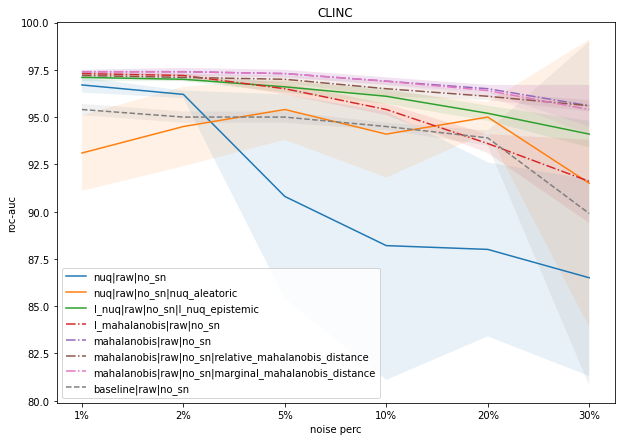

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

metric = 'roc-auc'
dataset = 'CLINC'

all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_nuq['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    noise_levels = []
    for noise_perc in noise_percs:
        full_method = method + f'|{noise_perc}'
        row = table_nuq.iloc[table_nuq['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        noise_levels.append(float(noise_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    noise_levels = [f'{l*100:.0f}%' for l in noise_levels]
    plt.plot(noise_levels, curve_mean, label='|'.join(full_method.split('|')[:3]))
    plt.fill_between(noise_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    

all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_nuqal['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    noise_levels = []
    for noise_perc in noise_percs:
        full_method = method + f'|{noise_perc}'
        row = table_nuqal.iloc[table_nuqal['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        noise_levels.append(float(noise_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    noise_levels = [f'{l*100:.0f}%' for l in noise_levels]
    plt.plot(noise_levels, curve_mean, label='|'.join(full_method.split('|')[:3] + [row['UE Score'].values[0]]))
    plt.fill_between(noise_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    
all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_lnuq['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    noise_levels = []
    for noise_perc in noise_percs:
        full_method = method + f'|{noise_perc}'
        row = table_lnuq.iloc[table_lnuq['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        noise_levels.append(float(noise_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    noise_levels = [f'{l*100:.0f}%' for l in noise_levels]
    plt.plot(noise_levels, curve_mean, label='|'.join(full_method.split('|')[:3] + [row['UE Score'].values[0]]))
    plt.fill_between(noise_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)


all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_lmaha['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    noise_levels = []
    for noise_perc in noise_percs:
        full_method = method + f'|{noise_perc}'
        row = table_lmaha.iloc[table_lmaha['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        noise_levels.append(float(noise_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    noise_levels = [f'{l*100:.0f}%' for l in noise_levels]
    plt.plot(noise_levels, curve_mean, '-.', label='|'.join(full_method.split('|')[:3]))
    plt.fill_between(noise_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)

    
all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_maha['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    noise_levels = []
    for noise_perc in noise_percs:
        full_method = method + f'|{noise_perc}'
        row = table_maha.iloc[table_maha['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        noise_levels.append(float(noise_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    noise_levels = [f'{l*100:.0f}%' for l in noise_levels]
    plt.plot(noise_levels, curve_mean, '-.', label='|'.join(full_method.split('|')[:3]))
    plt.fill_between(noise_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)

all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_mahar['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    noise_levels = []
    for noise_perc in noise_percs:
        full_method = method + f'|{noise_perc}'
        row = table_mahar.iloc[table_mahar['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        noise_levels.append(float(noise_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    noise_levels = [f'{l*100:.0f}%' for l in noise_levels]
    plt.plot(noise_levels, curve_mean, '-.', label='|'.join(full_method.split('|')[:3] + [row['UE Score'].values[0]]))
    plt.fill_between(noise_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)

all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_maham['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    noise_levels = []
    for noise_perc in noise_percs:
        full_method = method + f'|{noise_perc}'
        row = table_maham.iloc[table_maham['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        noise_levels.append(float(noise_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    noise_levels = [f'{l*100:.0f}%' for l in noise_levels]
    plt.plot(noise_levels, curve_mean, '-.', label='|'.join(full_method.split('|')[:3] + [row['UE Score'].values[0]]))
    plt.fill_between(noise_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)


all_methods = np.array(['|'.join(m.split('|')[:3]) for m in baselines_all.iloc[[0]]['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    noise_levels = []
    for noise_perc in noise_percs:
        full_method = method + f'|{noise_perc}'
        row = baselines_all.iloc[baselines_all['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        noise_levels.append(float(noise_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    noise_levels = [f'{l*100:.0f}%' for l in noise_levels]
    plt.plot(noise_levels, curve_mean, '--', label='|'.join(full_method.split('|')[:3]))#, color = 'r', marker='-')
    plt.fill_between(noise_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)

plt.legend()
plt.xticks(noise_levels)
plt.xlabel('noise perc')
plt.ylabel(metric)
plt.title(dataset)
plt.show()

In [4]:
import os 
def choose_agg_func(method):
    agg_methods = {
        "bald": bald,
        "sampled_max_prob": sampled_max_prob,
        "variance": probability_variance,
    }
    if method=='nuq' or method=='nuq_best' or method=='nuq_best1':
        nuq_aleatoric = lambda x: np.squeeze(x[0], axis=-1)
        nuq_epistemic = lambda x: np.squeeze(x[1], axis=-1)
        nuq_total = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {
            "nuq_aleatoric": nuq_aleatoric,
            "nuq_epistemic": nuq_epistemic,
            "nuq_total": nuq_total,
        }
    elif method=='decomposing_md':
        disc_md = lambda x: np.squeeze(x[0], axis=-1)
        nondisc_md = lambda x: np.squeeze(x[1], axis=-1)
        sum_md = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {"disc_md": disc_md, 
                       'nondisc_md': nondisc_md,
                       'disc+nondisc_md': sum_md}
    elif method=='mahalanobis':
        maha_dist = lambda x: np.squeeze(x[0], axis=-1)
        rel_maha_dist = lambda x: np.squeeze(x[1], axis=-1)
        marg_maha_dist = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {"mahalanobis_distance": maha_dist,
                       "relative_mahalanobis_distance": rel_maha_dist,
                       "marginal_mahalanobis_distance": marg_maha_dist}
    elif method=='l_nuq':
        nuq_aleatoric = lambda x: np.squeeze(x[0], axis=-1)
        nuq_epistemic = lambda x: np.squeeze(x[1], axis=-1)
        nuq_total = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {
            "l_nuq_aleatoric": nuq_aleatoric,
            "l_nuq_epistemic": nuq_epistemic,
            "l_nuq_total": nuq_total,
        }       
    elif method=='ddu' or method=='ddu_maha':
        ddu = lambda x: -np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"ddu": ddu}
    elif method=='l_mahalanobis':
        ddu = lambda x: np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"l_mahalanobis_distance": ddu}
    elif method=='sngp':
        sngp = lambda x: np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"sngp": sngp}
    elif method=='mc_mahalanobis':
        sm_maha_dist = lambda x: np.squeeze(x[:, 1:], axis=-1).max(1)
        agg_methods = {"sampled_mahalanobis_distance": sm_maha_dist}
    return agg_methods
metric_types=["roc-auc", 'pr-auc']

methods = ['nuq', 'mahalanobis', 'l_mahalanobis', 'l_nuq']
regs = ['raw']#, 'reg', 'metric']
spectralnorm = ['no_sn']#, 'no_sn']
dataset_names = ['ROSTD']
dataset_fnames = ['rostd']
noise_percs = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3]

names = []
tables = []
baselines = []
for method in methods:
    for reg in regs:
        for sn in spectralnorm:
            for noise_perc in noise_percs:
                run_dirs = []
                name_sn = ''
                names = [f'{method}|{reg}|{sn}|{noise_perc}']
                for name in dataset_fnames:
                    model_series_dir = f'../../workdir/run_tasks_for_model_series/electra_{reg}_{sn}/{name}/noise_perc_{noise_perc}/{method}'
                    print(model_series_dir)
                    run_dirs.append([model_series_dir])
                    agg_func = choose_agg_func(method)
                try:
                    res_df = collect_datasets(run_dirs, names, dataset_names, metric_types=metric_types, baselines={}, methods=agg_func)
                    baselines.append(res_df.iloc[-1:])
                    tables.append(res_df.iloc[:-1])
                except:
                    print('pass')
                    pass

../../workdir/run_tasks_for_model_series/electra_raw_no_sn/rostd/noise_perc_0.01/nuq
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/rostd/noise_perc_0.02/nuq
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/rostd/noise_perc_0.05/nuq
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/rostd/noise_perc_0.1/nuq
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/rostd/noise_perc_0.2/nuq
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/rostd/noise_perc_0.3/nuq
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/rostd/noise_perc_0.01/mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/rostd/noise_perc_0.02/mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/rostd/noise_perc_0.05/mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/rostd/noise_perc_0.1/mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/rostd/noise_perc_0.2/mahalanobis
../../workdir/run_tasks_for_mo

In [5]:
baselines_all = pd.concat([pd.concat(baselines)]).reset_index()
table_all = pd.concat([pd.concat(tables)]).reset_index()

table_nuq = table_all[(table_all['UE Score'] == 'nuq_epistemic')].reset_index(drop=True)
table_nuqal = table_all[(table_all['UE Score'] == 'nuq_aleatoric')].reset_index(drop=True)

table_lnuq = table_all[(table_all['UE Score'] == 'l_nuq_epistemic')].reset_index(drop=True)
table_lnuqal = table_all[(table_all['UE Score'] == 'l_nuq_aleatoric')].reset_index(drop=True)

table_maha = table_all[(table_all['UE Score'] == 'mahalanobis_distance')].reset_index(drop=True)
table_mahar = table_all[(table_all['UE Score'] == 'relative_mahalanobis_distance')].reset_index(drop=True)
table_maham = table_all[(table_all['UE Score'] == 'marginal_mahalanobis_distance')].reset_index(drop=True)

table_lmaha = table_all[(table_all['UE Score'] == 'l_mahalanobis_distance')].reset_index(drop=True)

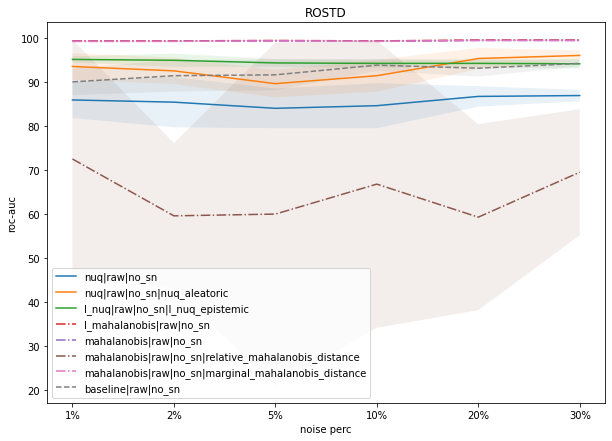

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

metric = 'roc-auc'
dataset = 'ROSTD'

all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_nuq['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    noise_levels = []
    for noise_perc in noise_percs:
        full_method = method + f'|{noise_perc}'
        row = table_nuq.iloc[table_nuq['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        noise_levels.append(float(noise_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    noise_levels = [f'{l*100:.0f}%' for l in noise_levels]
    plt.plot(noise_levels, curve_mean, label='|'.join(full_method.split('|')[:3]))
    plt.fill_between(noise_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    

all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_nuqal['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    noise_levels = []
    for noise_perc in noise_percs:
        full_method = method + f'|{noise_perc}'
        row = table_nuqal.iloc[table_nuqal['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        noise_levels.append(float(noise_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    noise_levels = [f'{l*100:.0f}%' for l in noise_levels]
    plt.plot(noise_levels, curve_mean, label='|'.join(full_method.split('|')[:3] + [row['UE Score'].values[0]]))
    plt.fill_between(noise_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    

all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_lnuq['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    noise_levels = []
    for noise_perc in noise_percs:
        full_method = method + f'|{noise_perc}'
        row = table_lnuq.iloc[table_lnuq['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        noise_levels.append(float(noise_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    noise_levels = [f'{l*100:.0f}%' for l in noise_levels]
    plt.plot(noise_levels, curve_mean, label='|'.join(full_method.split('|')[:3] + [row['UE Score'].values[0]]))
    plt.fill_between(noise_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)


all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_lmaha['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    noise_levels = []
    for noise_perc in noise_percs:
        full_method = method + f'|{noise_perc}'
        row = table_lmaha.iloc[table_lmaha['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        noise_levels.append(float(noise_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    noise_levels = [f'{l*100:.0f}%' for l in noise_levels]
    plt.plot(noise_levels, curve_mean, '-.', label='|'.join(full_method.split('|')[:3]))
    plt.fill_between(noise_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)

    
all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_maha['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    noise_levels = []
    for noise_perc in noise_percs:
        full_method = method + f'|{noise_perc}'
        row = table_maha.iloc[table_maha['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        noise_levels.append(float(noise_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    noise_levels = [f'{l*100:.0f}%' for l in noise_levels]
    plt.plot(noise_levels, curve_mean, '-.', label='|'.join(full_method.split('|')[:3]))
    plt.fill_between(noise_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)

all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_mahar['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    noise_levels = []
    for noise_perc in noise_percs:
        full_method = method + f'|{noise_perc}'
        row = table_mahar.iloc[table_mahar['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        noise_levels.append(float(noise_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    noise_levels = [f'{l*100:.0f}%' for l in noise_levels]
    plt.plot(noise_levels, curve_mean, '-.', label='|'.join(full_method.split('|')[:3] + [row['UE Score'].values[0]]))
    plt.fill_between(noise_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)

all_methods = np.array(['|'.join(m.split('|')[:3]) for m in table_maham['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    noise_levels = []
    for noise_perc in noise_percs:
        full_method = method + f'|{noise_perc}'
        row = table_maham.iloc[table_maham['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        noise_levels.append(float(noise_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    noise_levels = [f'{l*100:.0f}%' for l in noise_levels]
    plt.plot(noise_levels, curve_mean, '-.', label='|'.join(full_method.split('|')[:3] + [row['UE Score'].values[0]]))
    plt.fill_between(noise_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)


all_methods = np.array(['|'.join(m.split('|')[:3]) for m in baselines_all.iloc[[0]]['Method'].values])
for method in np.unique(all_methods):
    curve_mean = []
    curve_std = []
    noise_levels = []
    for noise_perc in noise_percs:
        full_method = method + f'|{noise_perc}'
        row = baselines_all.iloc[baselines_all['Method'].values == full_method]
        if not len(row):
            continue
        value = row[(dataset, metric)].values[0]
        curve_mean.append(float(value.split('±')[0]))
        curve_std.append(float(value.split('±')[1]))
        noise_levels.append(float(noise_perc))
    if len(curve_mean) < 2:
        continue
    curve_mean = np.array(curve_mean)
    curve_std = np.array(curve_std)
    noise_levels = [f'{l*100:.0f}%' for l in noise_levels]
    plt.plot(noise_levels, curve_mean, '--', label='|'.join(full_method.split('|')[:3]))#, color = 'r', marker='-')
    plt.fill_between(noise_levels, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)

plt.legend()
plt.xticks(noise_levels)
plt.xlabel('noise perc')
plt.ylabel(metric)
plt.title(dataset)
plt.show()